In [17]:
import gymnasium as gym
import numpy as np
import random
import wandb
from matplotlib import pyplot as plt

In [18]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: me21b145 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
sweep_config = {'method': 'random'}
metric = {
    'name': 'reward',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric
parameters = {
    'learning_rate': {'values': [0.1, 0.05, 0.01]},
    'discretization_bins': {'values': [100, 200, 300]},
    'episodes': {'values': [500, 750, 1000, 1500, 2000]},
    'temperature': {'values': [1000, 2000]},
    'discount_factor':{'value':0.99},
    }

sweep_config['parameters'] = parameters

import pprint
pprint.pprint(sweep_config)
sweep_id = wandb.sweep(sweep_config, project="RL_PA1_MountainCar_QLearning")

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'reward'},
 'parameters': {'discount_factor': {'value': 0.99},
                'discretization_bins': {'values': [100, 200, 300]},
                'episodes': {'values': [500, 750, 1000, 1500, 2000]},
                'learning_rate': {'values': [0.1, 0.05, 0.01]},
                'temperature': {'values': [1000, 2000]}}}
Create sweep with ID: 2cpoeij4
Sweep URL: https://wandb.ai/me21b145/RL_PA1_MountainCar_QLearning/sweeps/2cpoeij4


In [19]:
def train_q_learning(
    learning_rate=0.05,
    discount_factor=0.99,
    episodes=1000,
    discretization_bins=20,
    temperature=1000,
    is_wandb=False,
):
    env = gym.make("MountainCar-v0", render_mode = "None")
    env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=10000)
    
    state_bins = [discretization_bins] * len(env.observation_space.high)
    bin_width = (env.observation_space.high - env.observation_space.low) / state_bins
    
    def discretize_state(state):
        return tuple(((state - env.observation_space.low) / bin_width).astype(int))
    def softmax(x):
        exp_q = np.exp(x / temperature)
        probabilities = exp_q / np.sum(exp_q)
        return probabilities
    
    q_table = np.random.uniform(low=-2, high=0, size=(state_bins + [env.action_space.n]))
    rewards_per_episode = []
    return_per_episode = []
    
    for episode in range(episodes):
        state = discretize_state(env.reset()[0])
        total_reward = 0
        done = False
        time_steps = 0
        
        while not done:
            probabilities = softmax(q_table[state])
            sample = np.random.multinomial(1, probabilities)
            action = np.argmax(sample)
                
            next_state, reward, done, _, _ = env.step(action)
            next_state_discrete = discretize_state(next_state)

            current_q = q_table[state + (action,)]
            future_q = np.max(q_table[next_state_discrete])
            new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount_factor * future_q)
            q_table[state + (action,)] = new_q
            
            state = next_state_discrete
            total_reward += reward
            time_steps += 1
        
        rewards_per_episode.append(total_reward)
        if episode == 0:
            return_per_episode.append(total_reward)
        else:
            return_per_episode.append(return_per_episode[-1]*discount_factor + total_reward)
        print(episode, " episode done. Reward: ", total_reward)
        if is_wandb:
            wandb.log({'reward': total_reward, 'episode': episode})
            wandb.log({'length': time_steps, 'episode': episode})
        env.close()
    
    env.close()
    return q_table, rewards_per_episode, return_per_episode


In [14]:
def qlearning():
    env = gym.make("MountainCar-v0")
    env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=10000)
    config=None
    with wandb.init(config=config):
        q_table, rewards_per_episode = train_q_learning(
                                            wandb.config.learning_rate,
                                            wandb.config.discount_factor,
                                            wandb.config.episodes,
                                            wandb.config.discretization_bins,
                                            wandb.config.temperature,
                                            True)

        plt.figure(figsize=(12, 5))
        plt.plot(rewards_per_episode, label="Reward Per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title(f"Q Learning Training on Mountain Car with Discretization Size {wandb.config.discretization_bins}, Learning Rate {wandb.config.learning_rate}, Episodes {wandb.config.episodes}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'QLearning_Mountaincar_{wandb.config.discretization_bins}_{wandb.config.learning_rate}_{wandb.config.episodes}.png')

        wandb.log({'Discretization Size': wandb.config.discretization_bins, 'Learning Rate': wandb.config.learning_rate, 'Episodes': wandb.config.episodes, 'Rewards per episode': wandb.Image(plt)})
        plt.close()

        env.close() 

In [ ]:
wandb.agent(sweep_id, qlearning, count=5)

wandb: Agent Starting Run: cwsyay5n with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 200
wandb: 	episodes: 500
wandb: 	learning_rate: 0.01
wandb: 	temperature: 1000
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -50373.0
1  episode done. Reward:  -31988.0
2  episode done. Reward:  -38203.0
3  episode done. Reward:  -26208.0
4  episode done. Reward:  -24236.0
5  episode done. Reward:  -6002.0
6  episode done. Reward:  -35466.0
7  episode done. Reward:  -31234.0
8  episode done. Reward:  -4260.0
9  episode done. Reward:  -24376.0
10  episode done. Reward:  -66678.0
11  episode done. Reward:  -5386.0
12  episode done. Reward:  -7647.0
13  episode done. Reward:  -20927.0
14  episode done. Reward:  -82845.0
15  episode done. Reward:  -6446.0
16  episode done. Reward:  -113258.0
17  episode done. Reward:  -61933.0
18  episode done. Reward:  -45196.0
19  episode done. Reward:  -148313.0
20  episode done. Reward:  -15594.0
21  episode done. Reward:  -4496.0
22  episode done. Reward:  -20910.0
23  episode done. Reward:  -112535.0
24  episode done. Reward:  -43922.0
25  episode done. Reward:  -86071.0
26  episode done. Reward:  -34624.0
27  episode done. Reward:  -51924.0
28  e

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
length,▂▁▃▂▁▁▂▂▁▂▃▁▄▂▂▃▃█▃▇▃▁▃▁▂▂▂▁▂▁▁▁▁▁▂▂▂▃▁▃
reward,▇▇▄▇██▇██▇███▇▇▇▇▅█▅▆█▆█▄▇███▇▇▇▆▁█▇▇▃█▅
Discretization Size,200
Episodes,500
Learning Rate,0.01
episode,499
length,195162


wandb: Agent Starting Run: wkzfpzoa with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 1500
wandb: 	learning_rate: 0.1
wandb: 	temperature: 1000
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -64556.0
1  episode done. Reward:  -32918.0
2  episode done. Reward:  -21465.0
3  episode done. Reward:  -65417.0
4  episode done. Reward:  -74822.0
5  episode done. Reward:  -85764.0
6  episode done. Reward:  -20665.0
7  episode done. Reward:  -66651.0
8  episode done. Reward:  -42137.0
9  episode done. Reward:  -65065.0
10  episode done. Reward:  -43783.0
11  episode done. Reward:  -68017.0
12  episode done. Reward:  -59369.0
13  episode done. Reward:  -68616.0
14  episode done. Reward:  -95301.0
15  episode done. Reward:  -25534.0
16  episode done. Reward:  -4439.0
17  episode done. Reward:  -6118.0
18  episode done. Reward:  -105193.0
19  episode done. Reward:  -107003.0
20  episode done. Reward:  -142123.0
21  episode done. Reward:  -180851.0
22  episode done. Reward:  -58249.0
23  episode done. Reward:  -8719.0
24  episode done. Reward:  -32591.0
25  episode done. Reward:  -6481.0
26  episode done. Reward:  -19940.0
27  episode done. Reward:  -212427.0
2

wandb: Network error (ConnectionError), entering retry loop.


259  episode done. Reward:  -24838.0
260  episode done. Reward:  -7005.0
261  episode done. Reward:  -69469.0
262  episode done. Reward:  -19749.0
263  episode done. Reward:  -59896.0
264  episode done. Reward:  -8994.0
265  episode done. Reward:  -63268.0
266  episode done. Reward:  -8094.0
267  episode done. Reward:  -5661.0
268  episode done. Reward:  -67869.0
269  episode done. Reward:  -21818.0
270  episode done. Reward:  -227810.0
271  episode done. Reward:  -18056.0
272  episode done. Reward:  -23119.0
273  episode done. Reward:  -90246.0
274  episode done. Reward:  -24153.0
275  episode done. Reward:  -48672.0
276  episode done. Reward:  -61839.0
277  episode done. Reward:  -5280.0
278  episode done. Reward:  -17443.0
279  episode done. Reward:  -17355.0
280  episode done. Reward:  -161866.0
281  episode done. Reward:  -12125.0
282  episode done. Reward:  -4836.0
283  episode done. Reward:  -174953.0
284  episode done. Reward:  -53959.0
285  episode done. Reward:  -7926.0
286  

wandb: Network error (ConnectionError), entering retry loop.


599  episode done. Reward:  -22147.0
600  episode done. Reward:  -3043.0
601  episode done. Reward:  -125286.0
602  episode done. Reward:  -38761.0
603  episode done. Reward:  -85662.0
604  episode done. Reward:  -4208.0
605  episode done. Reward:  -119241.0
606  episode done. Reward:  -10968.0
607  episode done. Reward:  -66440.0
608  episode done. Reward:  -44607.0
609  episode done. Reward:  -55902.0
610  episode done. Reward:  -31619.0
611  episode done. Reward:  -112497.0
612  episode done. Reward:  -28859.0
613  episode done. Reward:  -15264.0
614  episode done. Reward:  -7669.0
615  episode done. Reward:  -105764.0
616  episode done. Reward:  -9523.0
617  episode done. Reward:  -37920.0
618  episode done. Reward:  -24741.0
619  episode done. Reward:  -56114.0
620  episode done. Reward:  -78912.0
621  episode done. Reward:  -10676.0
622  episode done. Reward:  -47314.0
623  episode done. Reward:  -4428.0
624  episode done. Reward:  -148138.0
625  episode done. Reward:  -26753.0
6

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇████
length,▄▁▁▃█▃▁▂▁▃▁▂▃▂▂▆▅▅▅▄▂▁▁▂▂▄▁▁▄▂▁▂▃▁▄▂▁▂▁▁
reward,▄█▇█▆▃▄▆▇▆█▆▇██▆▇██▂▂▇▅█▇█▇█▆▁▅▂▇█▆▆█▆█▆
Discretization Size,300
Episodes,1500
Learning Rate,0.1
episode,1499
length,16017


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8t4qsek8 with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 1000
wandb: 	learning_rate: 0.05
wandb: 	temperature: 1000
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -11629.0
1  episode done. Reward:  -16453.0
2  episode done. Reward:  -64120.0
3  episode done. Reward:  -60252.0
4  episode done. Reward:  -10375.0
5  episode done. Reward:  -52241.0
6  episode done. Reward:  -63716.0
7  episode done. Reward:  -44560.0
8  episode done. Reward:  -73126.0
9  episode done. Reward:  -39043.0
10  episode done. Reward:  -21232.0
11  episode done. Reward:  -214601.0
12  episode done. Reward:  -31222.0
13  episode done. Reward:  -2404.0
14  episode done. Reward:  -7177.0
15  episode done. Reward:  -66950.0
16  episode done. Reward:  -7068.0
17  episode done. Reward:  -18503.0
18  episode done. Reward:  -12547.0
19  episode done. Reward:  -12441.0
20  episode done. Reward:  -27386.0
21  episode done. Reward:  -72471.0
22  episode done. Reward:  -98517.0
23  episode done. Reward:  -30238.0
24  episode done. Reward:  -156129.0
25  episode done. Reward:  -2176.0
26  episode done. Reward:  -48576.0
27  episode done. Reward:  -219179.0
28 

Discretization Size,▁
Episodes,▁
Learning Rate,▁
episode,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
length,▂▁▂▁▂▁▁▂▂▃▂▂▂▂▁▁▁▂▂▂▂▃▁▃▁▁▁▃▂▅▁▄▂▁▂▂▂▂█▁
reward,▆▁▇▇█▇█▇█▇▄▇█▄▅▆▆███▆█▆▅▅█▇▇▅▇▇▆▇▆▇▆▇▇▆█
Discretization Size,300
Episodes,1000
Learning Rate,0.05
episode,999
length,2793


wandb: Agent Starting Run: 9jp96n4l with config:
wandb: 	discount_factor: 0.99
wandb: 	discretization_bins: 300
wandb: 	episodes: 1000
wandb: 	learning_rate: 0.05
wandb: 	temperature: 1000
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


0  episode done. Reward:  -113285.0
1  episode done. Reward:  -17883.0
2  episode done. Reward:  -144816.0
3  episode done. Reward:  -5789.0
4  episode done. Reward:  -2474.0
5  episode done. Reward:  -41187.0
6  episode done. Reward:  -24004.0
7  episode done. Reward:  -96639.0
8  episode done. Reward:  -3201.0
9  episode done. Reward:  -10937.0
10  episode done. Reward:  -45144.0
11  episode done. Reward:  -75520.0
12  episode done. Reward:  -6885.0
13  episode done. Reward:  -18961.0
14  episode done. Reward:  -50153.0
15  episode done. Reward:  -37752.0
16  episode done. Reward:  -19270.0
17  episode done. Reward:  -60227.0
18  episode done. Reward:  -12871.0
19  episode done. Reward:  -60397.0
20  episode done. Reward:  -14860.0
21  episode done. Reward:  -172195.0
22  episode done. Reward:  -26840.0
23  episode done. Reward:  -93623.0
24  episode done. Reward:  -17206.0
25  episode done. Reward:  -38956.0
26  episode done. Reward:  -85200.0
27  episode done. Reward:  -27320.0
28 

0  episode done. Reward:  -40450.0
1  episode done. Reward:  -11471.0
2  episode done. Reward:  -33580.0
3  episode done. Reward:  -5961.0
4  episode done. Reward:  -104216.0
5  episode done. Reward:  -79650.0
6  episode done. Reward:  -2530.0
7  episode done. Reward:  -12945.0
8  episode done. Reward:  -65104.0
9  episode done. Reward:  -28058.0
10  episode done. Reward:  -100269.0
11  episode done. Reward:  -12852.0
12  episode done. Reward:  -34587.0
13  episode done. Reward:  -227783.0
14  episode done. Reward:  -71992.0
15  episode done. Reward:  -15339.0
16  episode done. Reward:  -19383.0
17  episode done. Reward:  -24200.0
18  episode done. Reward:  -20388.0
19  episode done. Reward:  -4797.0
20  episode done. Reward:  -41844.0
21  episode done. Reward:  -12778.0
22  episode done. Reward:  -34110.0
23  episode done. Reward:  -47471.0
24  episode done. Reward:  -94808.0
25  episode done. Reward:  -48929.0
26  episode done. Reward:  -26765.0
27  episode done. Reward:  -48710.0
28

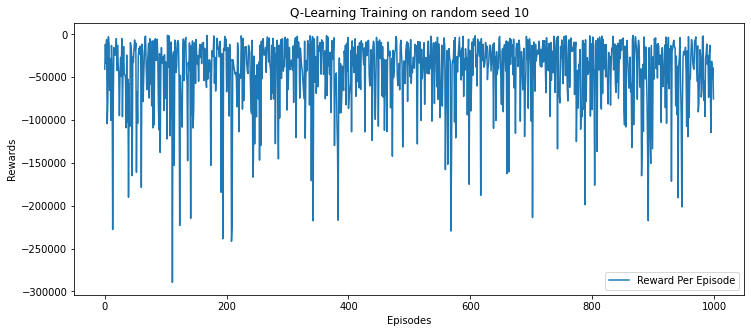

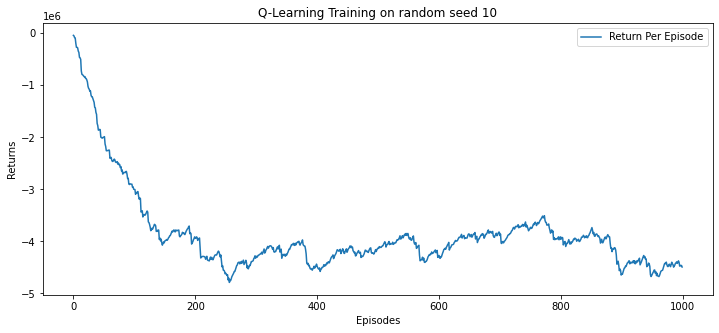

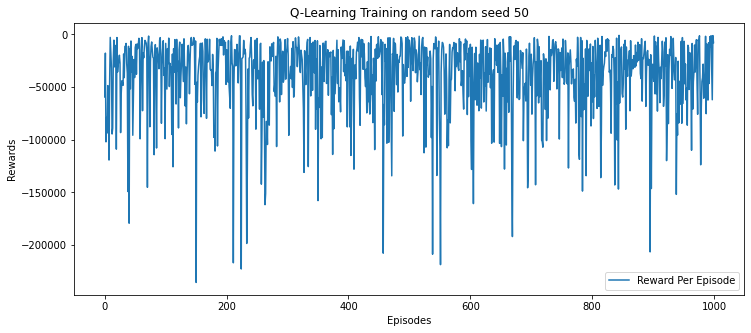

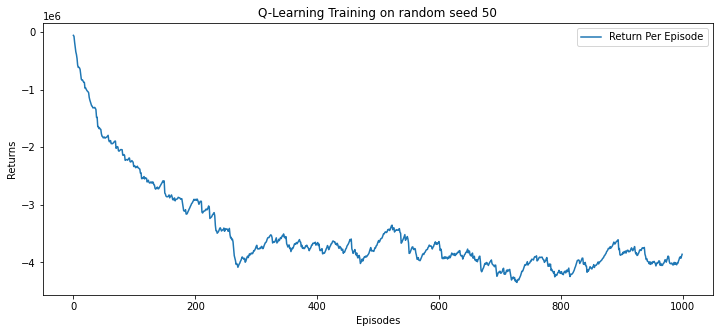

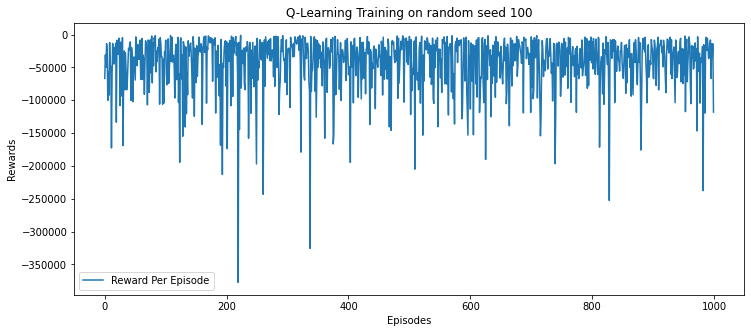

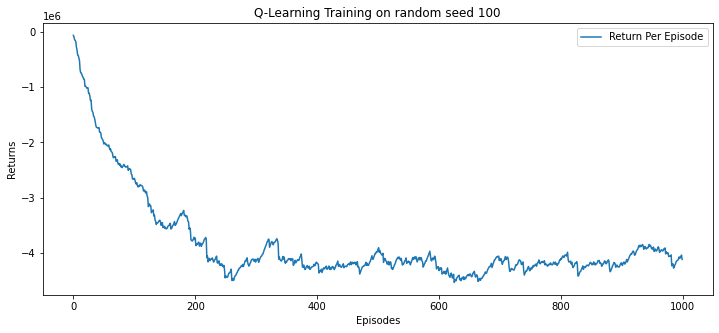

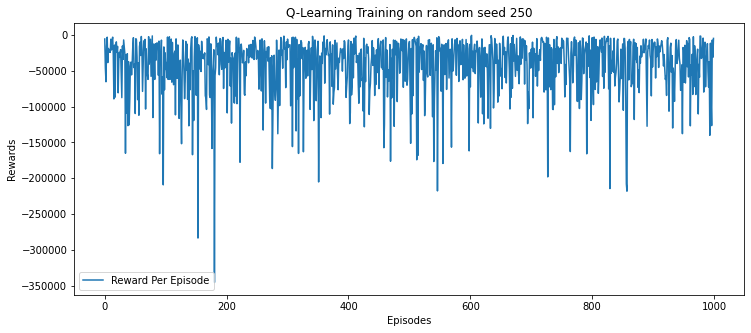

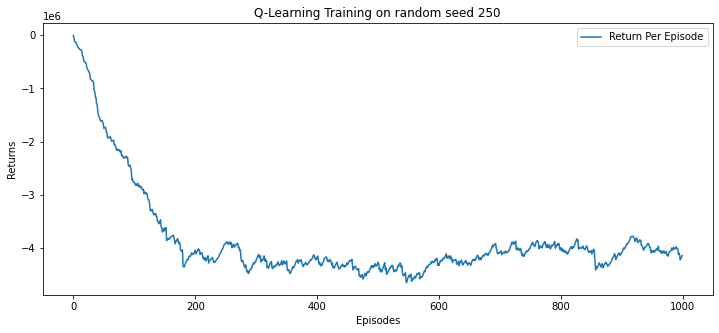

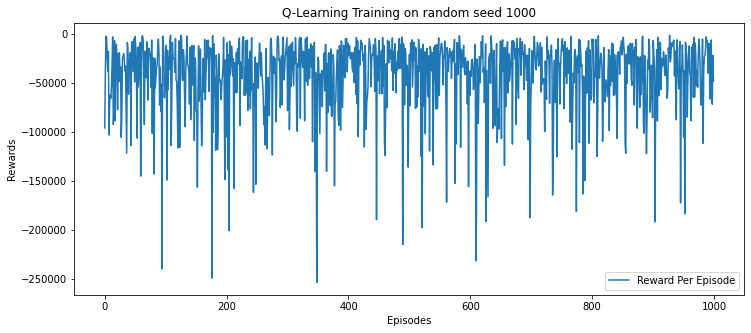

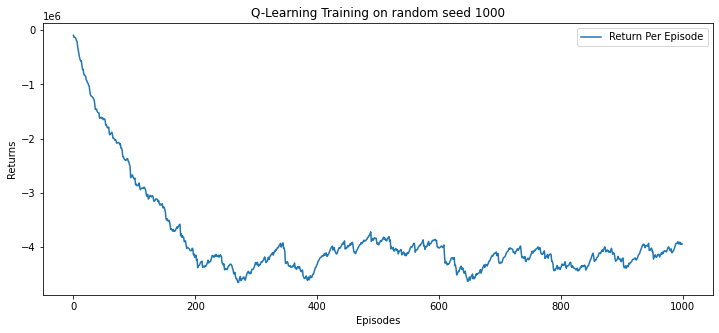

In [20]:
seeds = [10, 50, 100, 250, 1000]
rewards_avg = np.array([])
lengths_avg = np.array([])
rewards = np.array([])
for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    q_table, rewards_per_episode, return_per_episode = train_q_learning(#optimal parameters yet to be inputted
                                            learning_rate=0.01,
                                            discount_factor=0.99,
                                            episodes=1000,
                                            discretization_bins=100,
                                            temperature=2000,
                                            is_wandb=False)
    
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_per_episode, label="Reward Per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.title(f"Q-Learning Training on random seed {seed}")
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(return_per_episode, label="Return Per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"Q-Learning Training on random seed {seed}")
    plt.legend()
    print(f"Seed {seed} Done")